In [1]:
%matplotlib inline
import numpy as np
import pickle
import os
import time
import matplotlib.pyplot as plt
from py_dp.simulation.zigzag_structured import zigzag
from py_dp.simulation.linear_system_solver import LinearSystemStandard
from py_dp.dispersion.dispersion_network import dispersion_system_network
from py_dp.dispersion.dispersion_aux_classes import dispersionSaver
from py_dp.dispersion.dispersion_visualization_tools import save_big_data_array
from py_dp.dispersion.generate_transition_models import TransitionInfoStencilMethod, TransitionInfoExtendedStencil
from py_dp.dispersion.dispersion_models import DispModelStencilMethod, DispModelExtendedStencil
from py_dp.dispersion.transition_matrix_fcns import get_trans_matrix_single_attrib_both_methods, normalize_columns
from py_dp.dispersion.dispersion_visualization_tools import compare_trans_mat, compare_trans_mat_hist, compare_trans_mat_vtheta
from py_dp.dispersion.plot_wrapper_functions import plot_wrapper_with_saved_data, generate_plot_data
from py_dp.dispersion.dispersion_visualization_tools import model_holder, data_holder
from py_dp.dispersion.average_trajectories import average_all_realizations
from py_dp.dispersion.mapping_input import TemporalMapInput
from py_dp.dispersion.mapping import mapping_v_theta_repeat

This script contains the workflow for:
- generating zig zag networks, 
- solving a flow problem and performing particle tracking in the network
- extracting temporal Markov models (stencil method and extended-stencil
method)
- performing simulations using the Markov models
- comparing the Markov model results to the initial data

In [2]:
# specify a folder for saving the results of this script
case_folder = '/home/amirhossein/Desktop/example_script'

Fist create the network skeletons for the given number of nodes

In [3]:
# length of each link
l = 1.0
# link half angle
theta = np.pi/4
# number of nodes in one direction. The resulting network is n_nodes*n_nodes
n_nodes = 100
# specify 
boundaryType = 'non-periodic'
network = zigzag(n_nodes, n_nodes, l, theta, boundaryType=boundaryType)
# save the network in the case folder
network_path = os.path.join(case_folder, 'network.pkl')
with open(network_path,'wb') as output:
    pickle.dump(network,output,pickle.HIGHEST_PROTOCOL)

Next, we crate many realizations of this network by drawing the link 
transmissibilities from a lognormal distribution, impose a mean pressure
gradient on each realization of the network.
In each realization particles are injected in the center of the left 
boundary and tracked through the domain. We save these particle tracking for furthur analysis.

In [4]:
realz_folder = os.path.join(case_folder, 'realizations')
if not os.path.exists(realz_folder):
    os.mkdir(folder)
# Injection type of the particles, all particles are injected in the center
inj_type = "oneMiddle"
# number of realizations, increase this number for convergence in the MC data
n_runs = 10
# number of particles to inject in each realization
n_particles = 1000
# number of steps to follow each particle
n_steps = n_nodes-1
# standard deviation of the log-normal distribution
sigma = 1.0
# Dririchlet pressure of the left and right boundaries
p1 = 100.0
p2 = 0.0
# Find the index of the pores at the left and right boundaries
pore_x = network.pores.x
x1_target = 0.0
x2_target = network.network_length
idx1 = np.where(pore_x==x1_target)[0]
idx2 = np.where(pore_x==x2_target)[0]
# initialize a linear system for this network
# For each realization the transmissibilities of the network are updated
# and the system is solved again.
LS = LinearSystemStandard(network)
print 'Generating particle tracking data...'
for i in range(n_runs):
    if not i%2:
        print "realization: ", i
    # draw link transmissibilities from the log-normal distribution
    network.tube_trans_1phase = np.random.lognormal(sigma=sigma, size=network.nr_t)
    # assign new transmissibilities to the coefficients matrix
    LS.fill_matrix(network.tube_trans_1phase)
    # set dirichlet conditions
    LS.set_dirichlet_pores(idx1,p1)
    LS.set_dirichlet_pores(idx2,p2)
    # solve the flow problem for the current realization
    LS.solve()
    network.pores.p_n[:] = LS.sol
    # perform particle tracking for this realization
    dn1 = dispersion_system_network(network, n_particles, n_steps, injType=inj_type, verbose=False)
    dn1.follow_all_particles()
    # save the particle tracking results
    data_container = dispersionSaver(dn1.x_array, dn1.time_array, dn1.lastIndexArray, y_array = dn1.y_array)
    file_name = "real_" + str(i) + ".pkl"
    save_file = os.path.join(realz_folder,file_name)
    with open(save_file, 'wb') as output:
        pickle.dump(data_container, output, pickle.HIGHEST_PROTOCOL)

Generating particle tracking data...
realization:  0
realization:  2
realization:  4
realization:  6
realization:  8


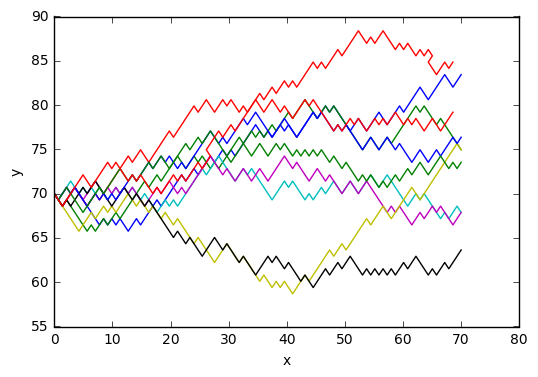

In [5]:
# plotting a sample from the particle evolution
fig, ax = plt.subplots(1,1)
for i in range(n_runs):
    ax.plot(dn1.x_array[i,:], dn1.y_array[i,:])
ax.set_xlabel('x')
ax.set_ylabel('y')

In [6]:
# for easier analysis all the combine all realizations in three big files
# containing the x, y, and time for each path
start_idx = 0
save_big_data_array(realz_folder, start_idx, n_runs)
# calculate the median time for one transition as a time scale
big_t_add = os.path.join(realz_folder, 'big_t.npy')
big_t = np.load(big_t_add)
t_scale = np.median(np.diff(big_t, axis=1))
t_scale_address = os.path.join(realz_folder, 't_scale.pkl')
with open(t_scale_address, 'wb') as output:
    pickle.dump(t_scale, output)

making large array from realizations...
saving big arrays


In [7]:
# save average trajectories for dt_stencil = coeff * t_scale
# Since the temporal model depends on average trajectories, averaging is perfomed once before
# extracting the stencils
coeff = 10.0
coeff_str = str(coeff).split('.')[0]
time_step = t_scale*coeff
avg_folder = os.path.join(realz_folder, 'time_averaged_' + coeff_str + 'dt')
if not os.path.exists(avg_folder):
    os.mkdir(avg_folder)
# every averaged data file includes the data from n_combine unaveraged data files
n_combine = 5
average_all_realizations(realz_folder, n_runs, time_step, avg_folder, n_combine=n_combine, prefix='real',
                         verbose=True, print_every=5)

averaging realizations...
reading realization nr  0
     -saving combined realizations
reading realization nr  5
     -saving combined realizations


In [8]:
# set result path
result_dir = os.path.join(case_folder, 'model_results')
# set path for saving matrix figures
matrix_folder_stencil = os.path.join(case_folder, 'matrix_pics_stencil')
matrix_folder_extended = os.path.join(case_folder, 'matrix_pics_extended')
# path for saving plume figures
savefig_path = os.path.join(case_folder, 'plume_pics')
# path for saving plot data
data_save_folder = os.path.join(case_folder, 'plume_pics_data')
for folder in [result_dir, matrix_folder_stencil, matrix_folder_extended,
               savefig_path, data_save_folder]:
    if not os.path.exists(folder):
        os.mkdir(folder)

Now we extract the stencil model and the correlated stencil model from 
the particle tracking data

In [ ]:
# 2. Extract the Markov models from the particle tracking data
# Now we extract the stencil model and the correlated stencil model from
# the particle tracking data

# total number of realizations for extracting the Markov model
n_realz = int(n_runs/n_combine)
# number of realizations used for creating bins. For a large number of total realizations n_bin_realz
# can be set to a smaller number
n_bin_realz = n_realz
# number of classes for log(v)
n_absv_class = 100
# number of additional class refinement for the very slow velocities
# if n_slow_classes is set a number larger than one the initial class will be divided into
# n_slow_class sub classes
n_slow_class = 1
# if max_allowed is not None, it would set the maximum bin size allowed for a velocity class
max_allowed = None
# number of angle classes
n_theta_class = 100
# Here we create a mapping between the velocity, angle and frequency of a velocity vector to
# an index for each state
map_input = TemporalMapInput(avg_folder, n_bin_realz, n_absv_class, n_theta_class, time_step, n_slow_class,
                             max_allowed, print_every=1, average_available=True)
mapping = mapping_v_theta_repeat(map_input.v_log_edges, map_input.theta_edges, map_input.v_array,
                                 map_input.theta_array, map_input.freq_array, make_aux_arrays=True)
# velocity-angle stecil
print 'Extracting velocity-angle stencil'
stencil_2d = TransitionInfoStencilMethod(avg_folder, n_realz, mapping, map_input, average_available=True)
lag = 1
transmat_2d = stencil_2d.get_trans_matrix(lag)
print '------------------------------------------------------------'
print 'Extracting the extended velocity-angle stencil'
# extended velocity-angle stencil
stencil_3d = TransitionInfoExtendedStencil(avg_folder, n_realz, mapping, map_input, average_available=True)
transmat_3d = stencil_3d.get_trans_matrix(lag)
print '------------------------------------------------------------'

number of output bins:  100
making auxillary arrays for mapping...
done
Extracting velocity-angle stencil
done
------------------------------------------------------------
Extracting the extended velocity-angle stencil
done
------------------------------------------------------------


In [ ]:
# 3. simulate the ensemble plume using the Stencil method

# run and save the simulated plume from the Markov models
x_max = None
# total number of particles
n_total = n_runs*n_particles
print 'simulating plume using the velocity-angle stencil'
model_2d = DispModelStencilMethod(n_total, n_steps, time_step, x_max, transmat_2d,
                                  stencil_2d.mapping, stencil_2d.init_class_count)
model_2d.follow_all_particles_vector()
# save the results in an object that will be used for plotting
result_holder = dispersionSaver(model_2d.x_array, model_2d.time_array, model_2d.last_index_array,
                             y_array = model_2d.y_array)
save_address = os.path.join(result_dir, 'stencil_2d.pkl')
with open(save_address, 'wb') as output:
    pickle.dump(result_holder, output, pickle.HIGHEST_PROTOCOL)
print '------------------------------------------------------------'
print 'simulating plume using the extended velocity-angle stencil'
model_3d = DispModelExtendedStencil(n_total, n_steps, time_step, x_max, transmat_3d,
                                    stencil_3d.mapping, stencil_3d.init_class_count)
model_3d.follow_all_particles_vector()
# save the results
result_holder = dispersionSaver(model_3d.x_array, model_3d.time_array, model_3d.last_index_array,
                             y_array = model_3d.y_array)
save_address = os.path.join(result_dir, 'stencil_3d.pkl')
with open(save_address, 'wb') as output:
    pickle.dump(result_holder, output, pickle.HIGHEST_PROTOCOL)
print '------------------------------------------------------------'

simulating plume using the velocity-angle stencil
step number:  0
step number:  50


In [ ]:
#plotting results
print 'plotting transition matrices'
print 'matrix plots will be saved in: ', matrix_folder_stencil, matrix_folder_extended
# plot the aggregate transition matrix and verify Chapman-Kolmogorov relation
lag_array = [1,5]
# extract the aggregate transition matrix for the lags specified in 
# lag_array
# We extract the transition matrices both for the stencil method and the extended stencil method.
v_mat_list, theta_mat_list, v_mat_list_nofreq, theta_mat_list_nofreq = \
            get_trans_matrix_single_attrib_both_methods(lag_array, n_realz, avg_folder, mapping, time_step,
                                                        average_available=True)
# plot results
for v_list, theta_list, mat_fig_folder, fstr in zip([v_mat_list, v_mat_list_nofreq],
                                                    [theta_mat_list, theta_mat_list_nofreq],
                                                    [matrix_folder_stencil, matrix_folder_extended],
                                                    ['stencil', 'extended']):
    column_folder = os.path.join(mat_fig_folder, 'columns')
    if not os.path.exists(column_folder):
        os.mkdir(column_folder)
    # making sure that sum of the columns of the transitions matrices is one
    trans_matrix_v1 = normalize_columns(v_list[0])
    trans_matrix_v2 = normalize_columns(v_list[1])
    trans_matrix_t1 = normalize_columns(theta_list[0])
    trans_matrix_t2 = normalize_columns(theta_list[1])
    # column-wise comparison of the aggregate transition probabilities
    v_str = 'v'+'_'+fstr
    theta_str = 'theta'+'_'+fstr
    both_str = 'both_matrix'+'_'+fstr
    column_array = [20, 50]
    compare_trans_mat_hist(trans_matrix_v1, trans_matrix_v2, lag, column_folder, v_str, legend_size=14,
                           col_array=column_array)
    compare_trans_mat_hist(trans_matrix_t1, trans_matrix_t2, lag, column_folder, theta_str, legend_size=14,
                           col_array=column_array)
    fontsize = 14
    plt.rcParams.update({'font.size':fontsize})
    plt.rc('xtick', labelsize=fontsize * 0.8)
    plt.rc('ytick', labelsize=fontsize * 0.8)
    compare_trans_mat(trans_matrix_v1, trans_matrix_v2, lag, mat_fig_folder, v_str)
    compare_trans_mat(trans_matrix_t1, trans_matrix_t2, lag, mat_fig_folder, theta_str)
    compare_trans_mat_vtheta(trans_matrix_v1, trans_matrix_t1, mat_fig_folder, both_str)

In [ ]:
print 'plotting the plume evolution'
print 'plume evolution plots saved at: ', savefig_path
# plot the plume evolution maps, the evolution of plume moments, and 
# breakthrough curves
multiplier = int(coeff)
stencil_names = ['stencil_2d.pkl', 'stencil_3d.pkl']
model_labels = [r'$(v, \theta)$', r'$(v, \theta, f)$']

# print stencil_dt
# load data and models
t1 = time.time()
print 'loading data'
data = data_holder(realz_folder)
t2 = time.time()
print 'elapsed time: ', t2 - t1
data_array = [data]
# Shift starting points to make sure all streamlines start from the origin
data.y_array = data.y_array - data.y_array[:,0][:, None]
data.x_array = data.x_array - data.x_array[:,0][:, None]

# finding the last time in data
tp1 = np.percentile(data.t_array[:, -1], 2)
t_end = min(data.t_array[:, -1])
model_array = []
# load all models
for i in range(len(stencil_names)):
    model_load_path = os.path.join(case_folder, 'model_results', stencil_names[i])
    current_label = model_labels[i]
    model = model_holder(model_load_path, current_label)
    model_array.append(model)
generate_plot_data(t_end, t_scale, time_step, data_save_folder, model_array, data, l, theta,
                   n_points_moments=12, n_steps_plumes=5, kdepoints=10000, n_pores=n_nodes)

plt.rcParams.update({'font.size': 20})
plt.rc('xtick', labelsize=14)
plt.rc('ytick', labelsize=14)
plt.rcParams.update({'figure.autolayout': True})
plt.rc('text', usetex=True)
plt.rc('font',**{'family':'serif','serif':['Stix']})
legend_size = 13
datalabel = r"$MC data$"
save_name = 'gauss01'
y_correction = 0.0
lw = 1
fmt = 'png'
plot_wrapper_with_saved_data(t_end, t_scale, time_step, data_save_folder, savefig_path, save_name, datalabel,
                             model_labels, l, theta, y_correction, lw, fmt, zoom_plots = False, n_pores=n_nodes)